In [ ]:
%load_ext autoreload
%autoreload 2

import xroms
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo

from pre_process import *
from possible_trash.plotting_funcs import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [11]:
# Find coordinates of midpoint of Sørvest F
target_lon = 5.0
target_lat = 56.8

i_loc, j_loc = get_windpark_midpoint_indices(test, target_lon, target_lat)

In [3]:
test = xroms.open_mfnetcdf(['/lustre/storeB/project/nwp/havvind/hav/results/experiment/EXP-02/norkyst_avg_0001.nc'])

test, xgrid = xroms.roms_dataset(test, include_cell_volume=True)

In [ ]:
def rossby_radius(f, rho, z_w, grid):
    '''
    Calculate the first Rossby radius using the WKB approximation.
    
    Parameters:
    f (float or ndarray): The Coriolis parameter
    rho (ndarray): The density profile as a function of depth, which 
                   can vary in space.
    z_w (ndarray): The depth levels
    grid (object): The grid object 

    Returns:
    R (ndarray): The calculated Rossby radius at the specified depth levels. 
                 The output is an array corresponding to the spatial 
                 dimensions defined in the grid.
    '''
    # Calculate buoyancy frequency squared
    N2 = xroms.N2(rho, grid)
    N2 = N2.fillna(0)
    
    # Take the square root to get buoyancy frequency
    N = np.sqrt(N2)

    # Interpolating from s-layer to z-depths (in meters)
    #depths = np.linspace(-2500, 0) 
    depths = np.arange(-3000, -520, 20)
    depths = np.insert(depths, len(depths), values=np.arange(-300, -105, 5), axis=0)
    depths = np.insert(depths, len(depths), values=np.arange(-100, -52, 2), axis=0)
    depths = np.insert(depths, len(depths), values=np.arange(-50, 1, 1), axis=0)
    N_sliced = N.xroms.zslice(grid, depths, z=z_w)
    N_sliced = N_sliced.fillna(0)

    # Buoyancy frequency integrated over depth
    N_int = N_sliced.integrate(coord='z_w')
    
    # WKB approx. of Rossby radius
    R = (1 / (np.abs(f) * np.pi)) * N_int

    return R

In [8]:
R_test = rossby_radius(test.f, test.rho, test.z_w, xgrid)

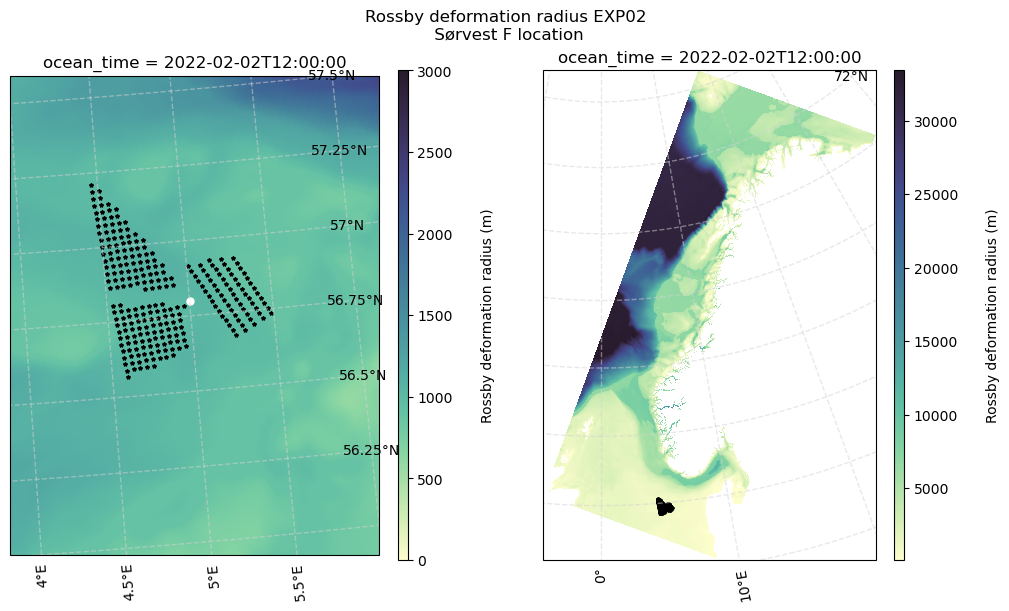

In [12]:
plot_map_Rossby_radius(test, R_test, sorvest_F, 'EXP02', None, i_loc, j_loc)